In [1]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
if platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
    sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
import subjects

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [ ]:
%matplotlib notebook
_, ax = plt.subplots()

In [33]:
# Create group data frame with placefield firing in each bin (0:50 = MAZE, 50:100 = reMAZE)
from copy import deepcopy
from neuropy.utils.mathutil import min_max_external_scaler

sessions = subjects.remaze_sess()[1:]  # RatSDay2NSD does not have remaze position info
kw = dict(frate_thresh=0, grid_bin=2)
separate_run_dir = False

tc_all, maze_all, remaze_all = [], [], []
pfcorr_by_dir = {}
for s, sess in enumerate([sessions[0]]):
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("pyr")
    
    # ---- Run direction separated-------
    if separate_run_dir:
        tc_maze, tc_remaze, maze_tc_comb, remaze_tc_comb = [], [], [], []
        for direction in ["up", "down"]:
            maze_run = sess.maze_run[direction]
            pfmaze = Pf1D(neurons, position=sess.maze, epochs=maze_run, **kw)
            maze_tc_comb.append(pfmaze.tuning_curves)
            tc_maze.append(pfmaze.resample_1D(50).tuning_curves)
    
            remaze_run = sess.remaze_run[direction]
            pfremaze = Pf1D(neurons, position=sess.remaze, epochs=remaze_run, **kw)
            remaze_tc_comb.append(pfremaze.tuning_curves)
            tc_remaze.append(pfremaze.resample_1D(50).tuning_curves)
    
        tc_comb = np.hstack((np.vstack(tc_maze), np.vstack(tc_remaze)))
        pfmaze.tuning_curves = np.concatenate(maze_tc_comb, axis=0)
        pfmaze.neuron_ids = np.concatenate((pfmaze.neuron_ids, pfmaze.neuron_ids * -1), axis=0)
        pfremaze.tuning_curves = np.concatenate(remaze_tc_comb, axis=0)
        pfremaze.neuron_ids = np.concatenate((pfremaze.neuron_ids, pfremaze.neuron_ids * -1), axis=0)
        

    # ---- Overall----
    else:
        
        pfmaze = Pf1D(neurons, position=sess.maze, **kw)
        pfremaze=Pf1D(neurons, position=sess.remaze, **kw)

In [30]:
sess

ProcessData(RatU_Day2NSD_2021-07-24_08-16-38.xml)

In [31]:
sess.paradigm

4 epochs
Snippet: 
    start   stop    label
0      0   9544      pre
1   9545  12855     maze
2  12856  45316     post
3  45317  48496  re-maze

In [34]:
from neuropy.analyses.decoders import Decode1d

decode_maze = Decode1d(neurons=neurons, ratemap=pfremaze, epochs=sess.paradigm['re-maze'], bin_size=0.5)

In [ ]:
np.unique(decode_maze.decoded_position[0])

In [ ]:
sess.maze.time.shape

In [ ]:
### Write code to get error in decoded position!!!

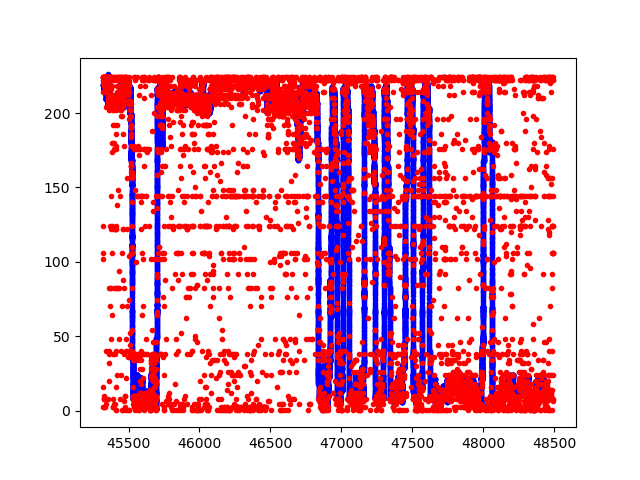

In [55]:
%matplotlib widget
_, ax = plt.subplots()
speed_thresh = pfremaze.speed > pfremaze.speed_thresh
ax.plot(sess.remaze.time[speed_thresh], sess.remaze.x[speed_thresh], 'b.')
t_decode = sess.paradigm['re-maze'].starts[0] + np.arange(decode_maze.nbins_epochs[0]) * decode_maze.bin_size
ax.plot(t_decode, decode_maze.decoded_position[0], 'r.')

# ax.set_xlim((9900, 10100))

In [28]:
pfmaze.speed_thresh

3

In [51]:
t_decode

array([ 9545. ,  9545.5,  9546. , ..., 12722. , 12722.5, 12723. ])

In [47]:
sess.remaze.speed.max()

179.0962419112418

In [56]:
pos_interp = np.interp(t_decode, sess.remaze.time, sess.remaze.x)
speed_interp = np.interp(t_decode, sess.remaze.time, sess.remaze.speed)
speed_interp_thresh_bool = speed_interp > 10
error = decode_maze.decoded_position[0] - pos_interp
error_moving = error[speed_interp_thresh_bool]
print(np.nanmean(np.abs(error_moving)))
print(np.nanstd(np.abs(error_moving)))


13.780680534934973
28.1082445229816


In [10]:
sess.maze.time[speed_thresh]

array([ 9549.        ,  9549.01666667,  9549.03333333, ...,
       12854.85      , 12854.86666667, 12854.88333333])

In [8]:
t_decode

array([ 9545. ,  9545.2,  9545.4, ..., 12854.2, 12854.4, 12854.6])

In [ ]:
decode_maze.decoded_position[0].shape

In [ ]:
pfmaze.speed

In [ ]:
_, ax = plt.subplots()
sns.heatmap(decode_maze.posterior[0], ax=ax, vmax=0.7, cmap='rocket_r')

In [ ]:
decode_maze.posterior[0].reshape(-1).min()

In [ ]:
decode_maze.decoded_position[0].shape

In [ ]:
sess.paradigm['maze'].durations


In [ ]:
decode_maze.decoded_position[0].shape[0] * 0.2

In [ ]:
sess.maze.x.shape

In [ ]:
decode_maze.decoded_position[0].shape

In [ ]:
pfmaze